# Training a Spatial Contrast (SC) Model

This notebook trains the Spatial Contrast model from [Sridhar et al., 2025](https://doi.org/10.1101/2024.03.05.583449) on marmoset retinal ganglion cell data.

The SC model extends the Linear-Nonlinear (LN) model by adding a local spatial contrast term:

$$y = a \cdot \log(1 + \exp(b \cdot (\text{imean} + w \cdot \text{lsc}) + c))$$

where:
- **imean** = spatially-weighted mean of the temporally filtered stimulus (same as in a standard LN model)
- **lsc** = local spatial contrast (spatially-weighted standard deviation)
- **w** = learnable weight controlling how much contrast influences the response
- **a, b, c** = learnable nonlinearity parameters

The spatial and temporal filters are frozen from pre-computed STAs. Only **4 scalar parameters** are learned.

In [1]:
import os

import hydra
import lightning
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from openretina.data_io.cyclers import LongCycler
from openretina.utils.file_utils import get_local_file_path

# Uncomment and change the path below if you want to use a custom cache directory:
# os.environ["OPENRETINA_CACHE_DIRECTORY"] = "/path/to/cache"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Configuration

Load the Hydra config for the SC model. Available configs:
- `sridhar_2025_nm_sc.yaml` -- natural movie dataset
- `sridhar_2025_wn_sc.yaml` -- white noise dataset

To train a different cell, change `cell_index` and `retina_index` in the config below. Everything else (STA file, input shape, etc.) is resolved automatically.

In [2]:
config_name = "sridhar_2025_nm_sc.yaml"

with hydra.initialize(config_path="../configs", version_base="1.3"):
    cfg = hydra.compose(config_name=config_name)

# To train a different cell, override here:
# cfg.dataloader.cell_index = 5
# cfg.dataloader.retina_index = "04"

print(f"Cell index: {cfg.dataloader.cell_index}")
print(f"Retina index: {cfg.dataloader.retina_index}")
print(f"STA file: {cfg.model.sta_file_name}")

Cell index: 272
Retina index: 01
STA file: cell_data_01_WN_stas_cell_272.npy


## Load data

On first run, the dataset will be downloaded to the cache directory.

In [3]:
dataloader = hydra.utils.instantiate(cfg.dataloader)

Loading all frames from: /mnt/big_storage/openretina_cache/gollisch_lab/sridhar_2025/marmoset/natural_movie/stimuli_padded_4 into memory


100%|██████████| 14544/14544 [00:16<00:00, 867.91it/s]


Random seed 1000 has been set.
train idx: [10 13 17 16  8  7  6 11  1 14  5  0  9  3 19 15]
val idx: [12 18 20  2  4]


## Instantiate the model

The config resolves `in_shape`, `sta_file_name`, and `flip_sta` automatically via Hydra interpolation. The only manual step is resolving `sta_dir` to a local path (since the config stores it as a remote URL that the dataloader downloads).

In [4]:
# Resolve the STA directory to a local path (the dataloader already downloaded the data)
cfg.model.sta_dir = get_local_file_path(str(cfg.model.sta_dir))

model = hydra.utils.instantiate(cfg.model)

print(f"Input shape: {list(cfg.model.in_shape)}")
print(f"STA file: {cfg.model.sta_file_name}")
print(f"RF location (from Gaussian fit): {model.rf_location}")
print(f"Gaussian fit success: {model.gaussian_params['success']}")
print(f"Spatial filter shape: {model.spatial_filter.shape}")
print(f"Temporal filter length: {model.temporal_filter.shape[0]}")

Input shape: [1, 30, 80, 90]
STA file: cell_data_01_WN_stas_cell_272.npy
RF location (from Gaussian fit): (50, 36)
Gaussian fit success: True
Spatial filter shape: torch.Size([15, 15])
Temporal filter length: 30


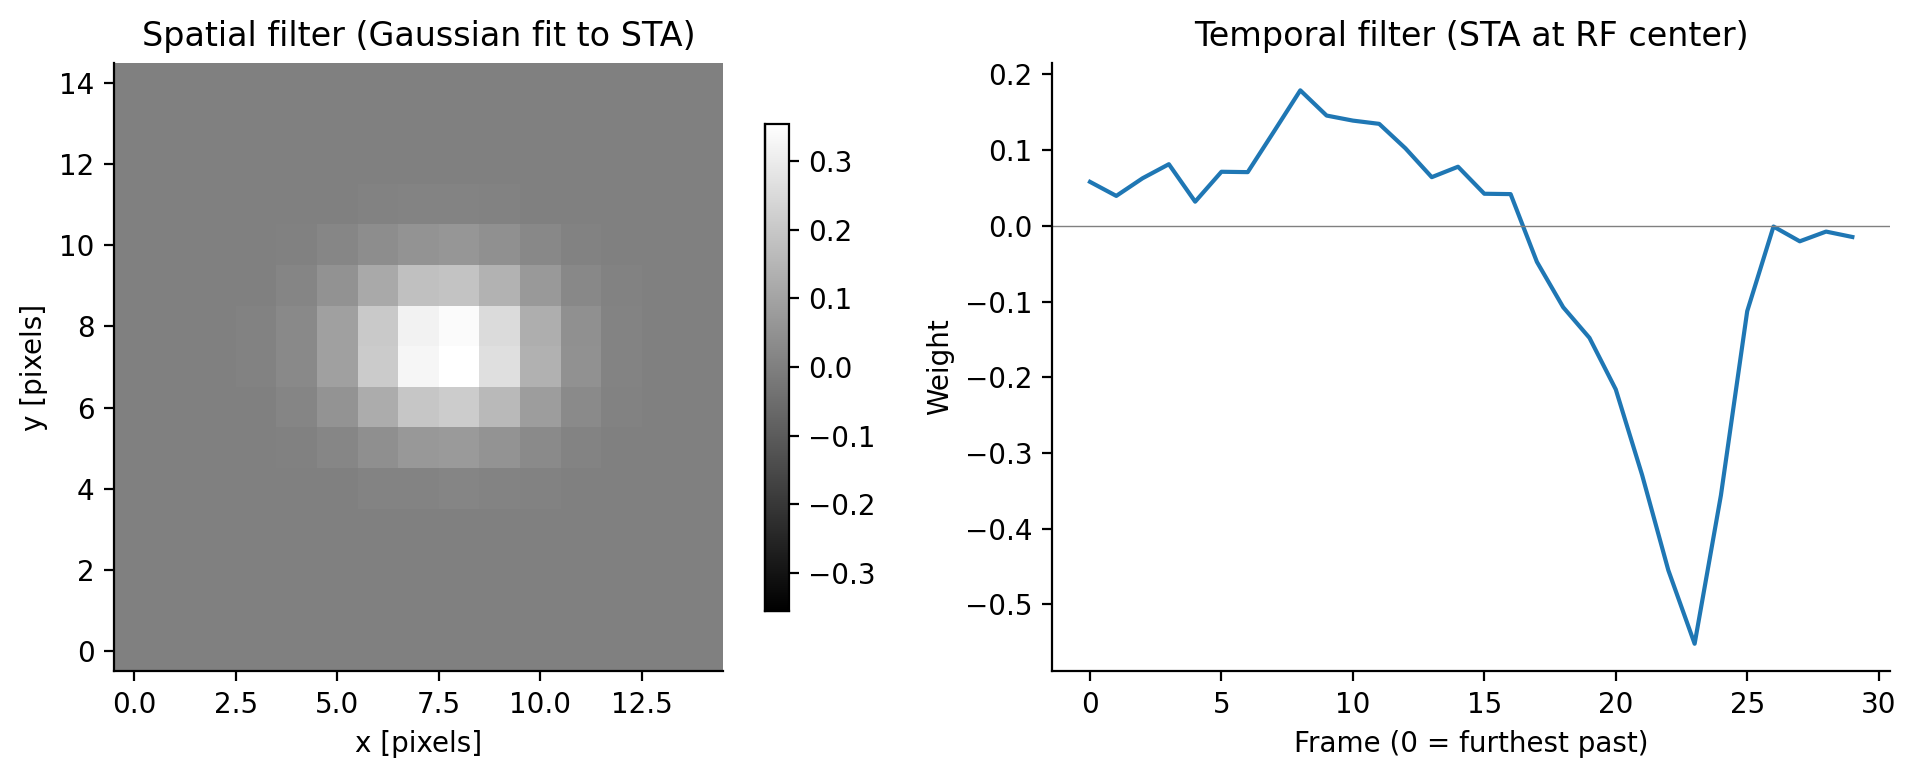

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Spatial filter (Gaussian fit to the STA, masked to sigma_contour std devs)
spat_filter = model.spatial_filter.cpu().numpy()
vm = np.max(np.abs(spat_filter))
im = ax1.imshow(spat_filter, cmap="gray", origin="lower", vmin=-vm, vmax=vm)
ax1.set_title("Spatial filter (Gaussian fit to STA)")
ax1.set_xlabel("x [pixels]")
ax1.set_ylabel("y [pixels]")
plt.colorbar(im, ax=ax1, shrink=0.8)

# Temporal filter (STA time course at RF center)
temp = model.temporal_filter.cpu().numpy()
time_axis = np.arange(len(temp))
ax2.plot(time_axis, temp)
ax2.axhline(0, color="gray", linewidth=0.5)
ax2.set_title("Temporal filter (STA at RF center)")
ax2.set_xlabel("Frame (0 = furthest past)")
ax2.set_ylabel("Weight")
sns.despine()

plt.tight_layout()
plt.show()

In [6]:
num_learnable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Learnable parameters ({num_learnable} total):")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.data.item():.4f}")

Learnable parameters (4 total):
  w: 0.0000
  nonlinearity.a: 4.0000
  nonlinearity.b: 1.0000
  nonlinearity.c: -5.0000


## Training

In [7]:
os.makedirs(
    cfg.paths.log_dir,
    exist_ok=True,
)

early_stopping = lightning.pytorch.callbacks.EarlyStopping(
    monitor="val_correlation",
    patience=10,
    mode="max",
    verbose=False,
    min_delta=0.001,
)

lr_monitor = lightning.pytorch.callbacks.LearningRateMonitor(logging_interval="epoch")

model_checkpoint = lightning.pytorch.callbacks.ModelCheckpoint(
    monitor="val_correlation", mode="max", save_weights_only=False
)

In [8]:
trainer = lightning.Trainer(
    max_epochs=10000,
    logger=None,
    callbacks=[early_stopping, lr_monitor, model_checkpoint],
    accelerator="gpu",
    log_every_n_steps=10,
)

train_loader = LongCycler(dataloader["train"])
val_loader = LongCycler(dataloader["validation"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                        | Params | Mode  | FLOPs
--------------------------------------------------------------------------------
0 | loss            | PoissonLoss3d               | 0      | train | 0    
1 | validation_loss | CorrelationLoss3d           | 0      | train | 0    
2 | nonlinearity    | SpatialContrastNonlinearity | 3      | train | 0    
  | other params    | n/a                         | 1      | n/a   | n/a  
--------------------------------------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Results

Inspect the learned parameters and compare predictions to the held-out test data (a repeated stimulus shared across all cells).

In [13]:
print("Trained parameters:")
print(f"  w (spatial contrast weight): {model.w.data.item():.4f}")
print(f"  a (output scaling):          {model.nonlinearity.a.data.item():.4f}")
print(f"  b (input gain):              {model.nonlinearity.b.data.item():.4f}")
print(f"  c (offset):                  {model.nonlinearity.c.data.item():.4f}")

Trained parameters:
  w (spatial contrast weight): 0.6985
  a (output scaling):          2.6474
  b (input gain):              0.9428
  c (offset):                  -3.9031


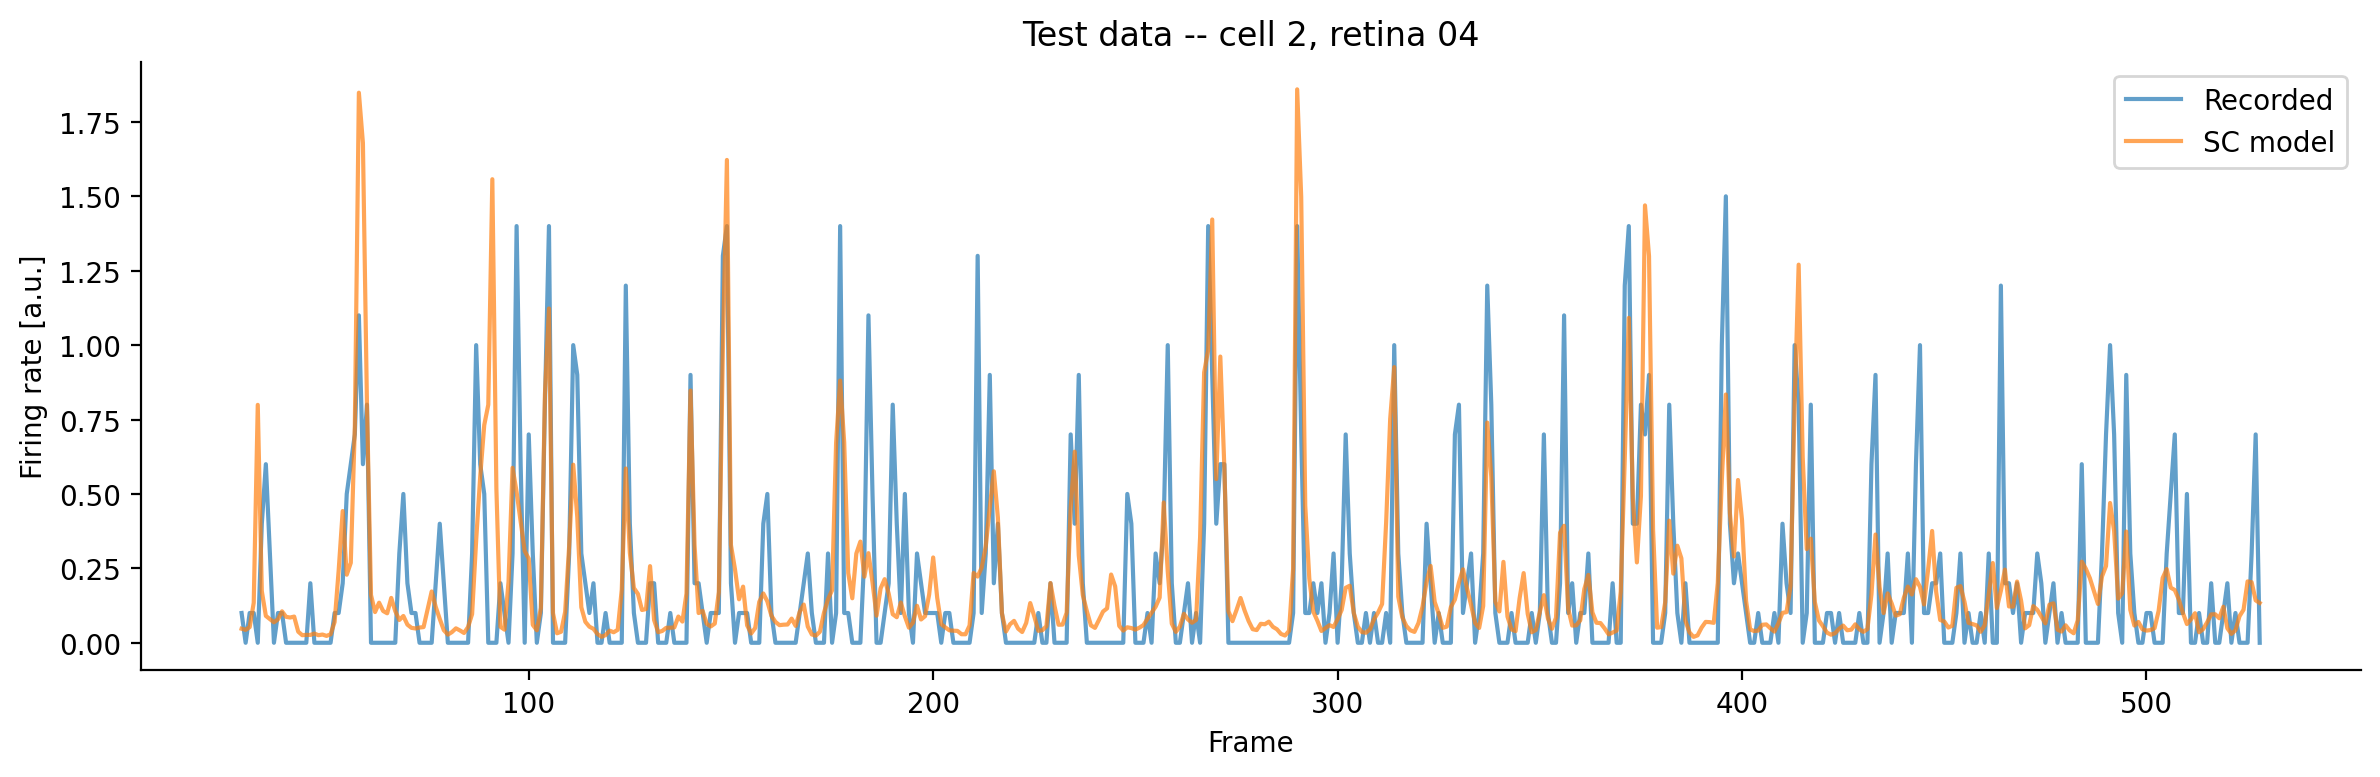

In [16]:
# Plot model predictions vs recorded response on the test stimulus
retina_index = cfg.dataloader.retina_index
test_dataset = dataloader["test"][retina_index].dataset

model.eval()
model.cpu()

with torch.no_grad():
    # movies shape is (1, time, h, w); add a channel dim -> (batch, channel, time, h, w)
    test_inputs = test_dataset.movies.unsqueeze(1)
    test_predictions = model(test_inputs).squeeze().numpy()

test_targets = test_dataset.responses.squeeze().numpy()

# The model output is shorter than the target by (temporal_filter_length - 1) frames
n_cut = test_targets.shape[0] - test_predictions.shape[0]

window = min(500, test_predictions.shape[0])
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.arange(n_cut, n_cut + window), test_targets[n_cut:n_cut + window], label="Recorded", alpha=0.7)
ax.plot(np.arange(n_cut, n_cut + window), test_predictions[:window], label="SC model", alpha=0.7)
ax.set_xlabel("Frame")
ax.set_ylabel("Firing rate [a.u.]")
ax.set_title(f"Test data -- cell {cfg.dataloader.cell_index}, retina {retina_index}")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()